# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 0            
model_seed = 0           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 400      
dataset_type = "poison"    
dataset_quantities = [0, 10, 20, 50, 100]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the model module name
from minima_volume.models import swiss_model_data as model_module

test_dataset_size = 2000

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    base_data_size=base_data_size,
    dataset_quantities=dataset_quantities,
    test_dataset_size=test_dataset_size,
    noise=0.3, # default swiss params
    extra_pts=1000,
    dataset_type=dataset_type,
    seed=data_seed
)

# Swiss specific initialization parameters
input_dim = 2
output_dim = 1
hidden_dims = [32]*5

# Grab model
model_template = model_module.get_model(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=output_dim, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 0.6884 | Test Loss 0.6928 | accs Train 0.5725 Test 0.5000
Epoch 100/2000: Train Loss 0.5159 | Test Loss 0.5772 | accs Train 0.7000 Test 0.6418
Epoch 200/2000: Train Loss 0.0234 | Test Loss 0.1278 | accs Train 0.9925 Test 0.9745
Epoch 300/2000: Train Loss 0.0060 | Test Loss 0.1337 | accs Train 1.0000 Test 0.9795
Epoch 400/2000: Train Loss 0.0008 | Test Loss 0.1370 | accs Train 1.0000 Test 0.9810
Epoch 500/2000: Train Loss 0.0003 | Test Loss 0.1422 | accs Train 1.0000 Test 0.9818
Epoch 600/2000: Train Loss 0.0002 | Test Loss 0.1451 | accs Train 1.0000 Test 0.9818
Epoch 700/2000: Train Loss 0.0001 | Test Loss 0.1451 | accs Train 1.0000 Test 0.9820
Epoch 800/2000: Train Loss 0.0001 | Test Loss 0.1445 | accs Train 1.0000 Test 0.9820
Epoch 900/2000: Train Loss 0.0001 | Test Loss 0.1440 | accs Train 1.0000 Test 0.9822
Epoch 1000/2000: Train Loss 0.0001 | Test Loss 0.1438 | accs Train 1.0000 Test 0.9822
Epoch 1100/2000: Train Loss 0.0000 | Test Loss 0.1428 | accs Train

Epoch 100/1000: Train Loss 0.1904 | Test Loss 1.2123 | accs Train 0.9000 Test 0.6130


Epoch 200/1000: Train Loss 0.0048 | Test Loss 3.6333 | accs Train 1.0000 Test 0.6172


Epoch 300/1000: Train Loss 0.0005 | Test Loss 4.2644 | accs Train 1.0000 Test 0.6195


Epoch 400/1000: Train Loss 0.0002 | Test Loss 4.5421 | accs Train 1.0000 Test 0.6190


Epoch 500/1000: Train Loss 0.0001 | Test Loss 4.7210 | accs Train 1.0000 Test 0.6188


Epoch 600/1000: Train Loss 0.0001 | Test Loss 4.8526 | accs Train 1.0000 Test 0.6180


Epoch 700/1000: Train Loss 0.0001 | Test Loss 4.9550 | accs Train 1.0000 Test 0.6185


Epoch 800/1000: Train Loss 0.0000 | Test Loss 5.0394 | accs Train 1.0000 Test 0.6190


Epoch 900/1000: Train Loss 0.0000 | Test Loss 5.1101 | accs Train 1.0000 Test 0.6185


Epoch 1000/1000: Train Loss 0.0000 | Test Loss 5.1699 | accs Train 1.0000 Test 0.6192
Completed training with 0 additional samples of data
Epoch 1/1000: Train Loss 0.6898 | Test Loss 0.6926 | accs Train 0.5600 Test 0.5000


Epoch 100/1000: Train Loss 0.3318 | Test Loss 0.9050 | accs Train 0.8400 Test 0.6255


Epoch 200/1000: Train Loss 0.1063 | Test Loss 2.5634 | accs Train 0.9400 Test 0.5935


Epoch 300/1000: Train Loss 0.0575 | Test Loss 3.4665 | accs Train 0.9800 Test 0.6360


Epoch 400/1000: Train Loss 0.0186 | Test Loss 4.4117 | accs Train 1.0000 Test 0.6565


Epoch 500/1000: Train Loss 0.0024 | Test Loss 5.4001 | accs Train 1.0000 Test 0.6765


Epoch 600/1000: Train Loss 0.0009 | Test Loss 5.7611 | accs Train 1.0000 Test 0.6870


Epoch 700/1000: Train Loss 0.0005 | Test Loss 5.9667 | accs Train 1.0000 Test 0.6923


Epoch 800/1000: Train Loss 0.0003 | Test Loss 6.1055 | accs Train 1.0000 Test 0.6970


Epoch 900/1000: Train Loss 0.0002 | Test Loss 6.2100 | accs Train 1.0000 Test 0.6997


Epoch 1000/1000: Train Loss 0.0002 | Test Loss 6.2990 | accs Train 1.0000 Test 0.7025
Completed training with 30 additional samples of data
Epoch 1/1000: Train Loss 0.6974 | Test Loss 0.6923 | accs Train 0.4750 Test 0.5000


Epoch 100/1000: Train Loss 0.4798 | Test Loss 0.6707 | accs Train 0.7083 Test 0.6270


Epoch 200/1000: Train Loss 0.2029 | Test Loss 0.7486 | accs Train 0.9083 Test 0.7582


Epoch 300/1000: Train Loss 0.0646 | Test Loss 0.7200 | accs Train 1.0000 Test 0.8720


Epoch 400/1000: Train Loss 0.0019 | Test Loss 0.7250 | accs Train 1.0000 Test 0.9133


Epoch 500/1000: Train Loss 0.0005 | Test Loss 0.7637 | accs Train 1.0000 Test 0.9163


Epoch 600/1000: Train Loss 0.0003 | Test Loss 0.7964 | accs Train 1.0000 Test 0.9177


Epoch 700/1000: Train Loss 0.0002 | Test Loss 0.8239 | accs Train 1.0000 Test 0.9183


Epoch 800/1000: Train Loss 0.0001 | Test Loss 0.8418 | accs Train 1.0000 Test 0.9193


Epoch 900/1000: Train Loss 0.0001 | Test Loss 0.8546 | accs Train 1.0000 Test 0.9197


Epoch 1000/1000: Train Loss 0.0001 | Test Loss 0.8645 | accs Train 1.0000 Test 0.9203
Completed training with 100 additional samples of data
Epoch 1/1000: Train Loss 0.6934 | Test Loss 0.6922 | accs Train 0.5125 Test 0.5000


Epoch 100/1000: Train Loss 0.5296 | Test Loss 0.5817 | accs Train 0.6750 Test 0.6488


Epoch 200/1000: Train Loss 0.0200 | Test Loss 0.0319 | accs Train 0.9969 Test 0.9912


Epoch 300/1000: Train Loss 0.0020 | Test Loss 0.0108 | accs Train 1.0000 Test 0.9965


Epoch 400/1000: Train Loss 0.0006 | Test Loss 0.0092 | accs Train 1.0000 Test 0.9970


Epoch 500/1000: Train Loss 0.0003 | Test Loss 0.0091 | accs Train 1.0000 Test 0.9970


Epoch 600/1000: Train Loss 0.0002 | Test Loss 0.0092 | accs Train 1.0000 Test 0.9972


Epoch 700/1000: Train Loss 0.0001 | Test Loss 0.0094 | accs Train 1.0000 Test 0.9972


Epoch 800/1000: Train Loss 0.0001 | Test Loss 0.0096 | accs Train 1.0000 Test 0.9975


Epoch 900/1000: Train Loss 0.0001 | Test Loss 0.0098 | accs Train 1.0000 Test 0.9972


Epoch 1000/1000: Train Loss 0.0000 | Test Loss 0.0100 | accs Train 1.0000 Test 0.9975
Completed training with 300 additional samples of data
Epoch 1/1000: Train Loss 0.6934 | Test Loss 0.6922 | accs Train 0.5125 Test 0.5000


Epoch 100/1000: Train Loss 0.5600 | Test Loss 0.5936 | accs Train 0.6861 Test 0.6567


Epoch 200/1000: Train Loss 0.0357 | Test Loss 0.0370 | accs Train 0.9903 Test 0.9918


Epoch 300/1000: Train Loss 0.0023 | Test Loss 0.0117 | accs Train 1.0000 Test 0.9958


Epoch 400/1000: Train Loss 0.0006 | Test Loss 0.0118 | accs Train 1.0000 Test 0.9962


Epoch 500/1000: Train Loss 0.0003 | Test Loss 0.0122 | accs Train 1.0000 Test 0.9968


Epoch 600/1000: Train Loss 0.0002 | Test Loss 0.0127 | accs Train 1.0000 Test 0.9968


Epoch 700/1000: Train Loss 0.0001 | Test Loss 0.0130 | accs Train 1.0000 Test 0.9968


Epoch 800/1000: Train Loss 0.0001 | Test Loss 0.0134 | accs Train 1.0000 Test 0.9968


Epoch 900/1000: Train Loss 0.0001 | Test Loss 0.0136 | accs Train 1.0000 Test 0.9968


Epoch 1000/1000: Train Loss 0.0000 | Test Loss 0.0139 | accs Train 1.0000 Test 0.9968
Completed training with 700 additional samples of data


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 0.1318 | accs: 0.9832
  10 samples | Test Loss: 0.2736 | accs: 0.9585
  20 samples | Test Loss: 0.4152 | accs: 0.9333
  50 samples | Test Loss: 0.8035 | accs: 0.8740
 100 samples | Test Loss: 0.5872 | accs: 0.8270

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model   10 | Train Loss: 0.0031 | accs: 0.9975
 Model   20 | Train Loss: 0.0100 | accs: 0.9950
 Model   50 | Train Loss: 0.0593 | accs: 0.9775
 Model  100 | Train Loss: 0.1451 | accs: 0.9550

Dataset type: poison, additional samples: 10
 Model    0 | Train Loss: 0.2780 | accs: 0.9756
 Model   10 | Train Loss: 0.0070 | accs: 0.9951
 Model   20 | Train Loss: 0.0145 | accs: 0.9927
 Model   50 | Train Loss: 0.0688 | accs: 0.9732
 Model  100 | Train Loss: 0.1570 | accs: 0.9488

Dataset type: poison, additional samples: 20
 Model    0 | Train Loss: 0.5703 | accs: 0.9524
 Model   10 | Train Los

### Model + Data Specific Verification

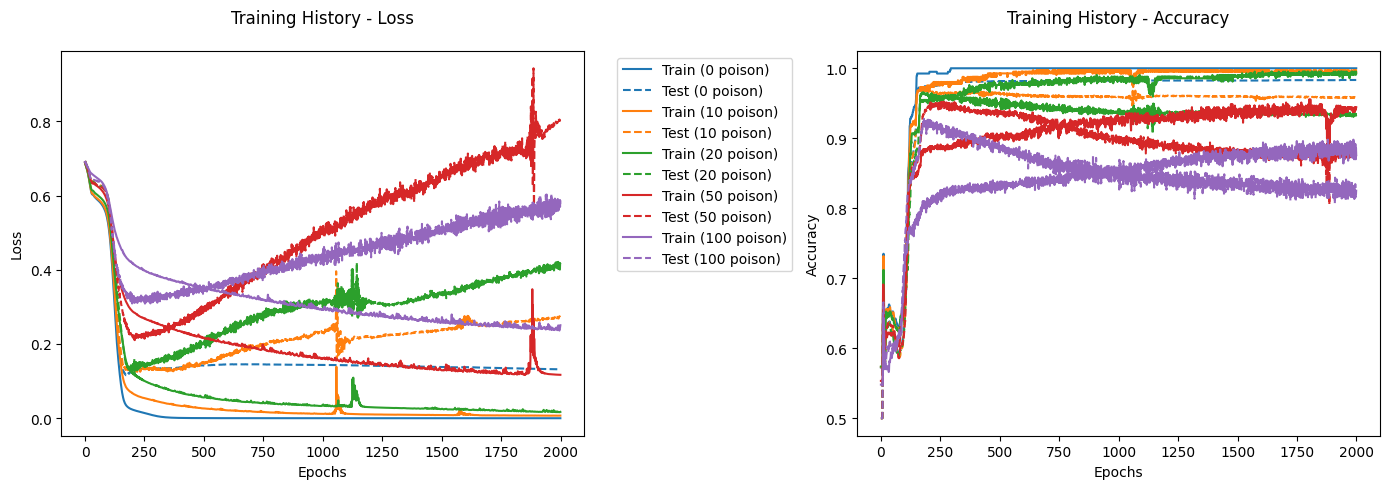

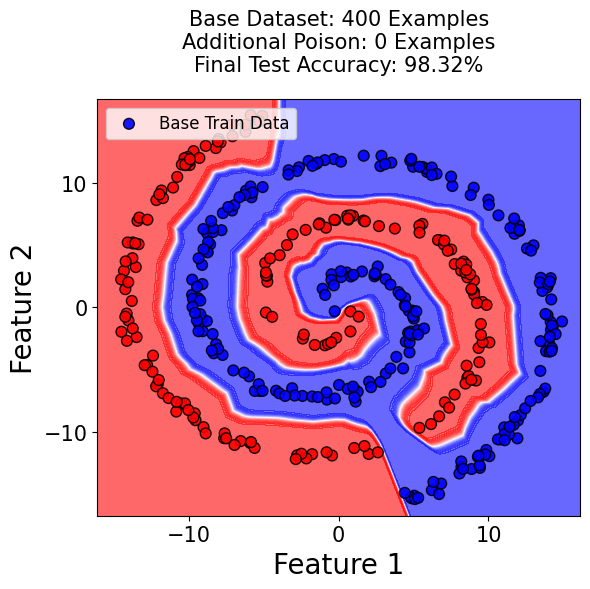

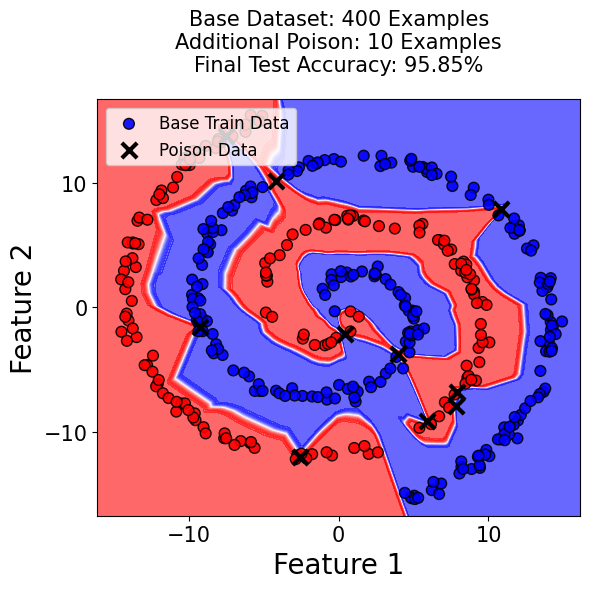

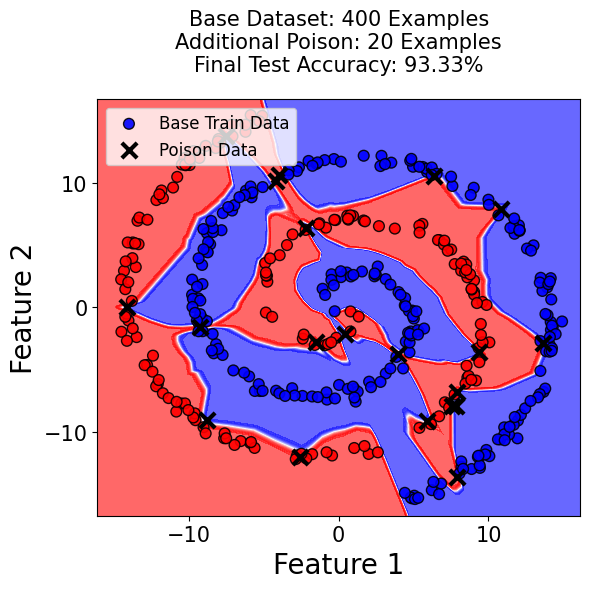

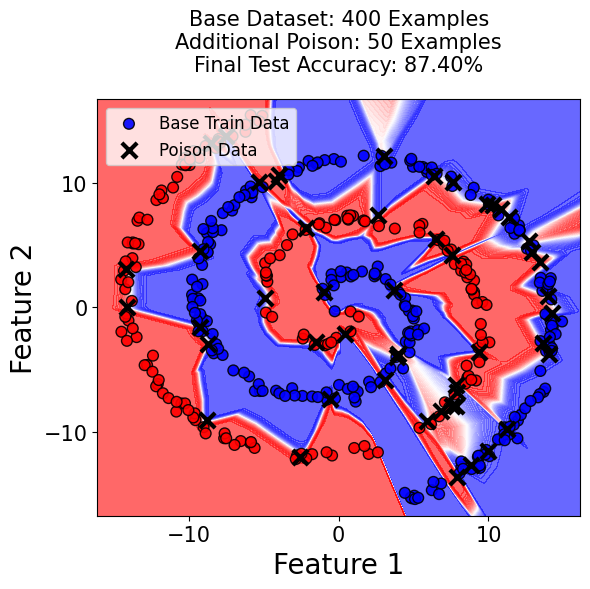

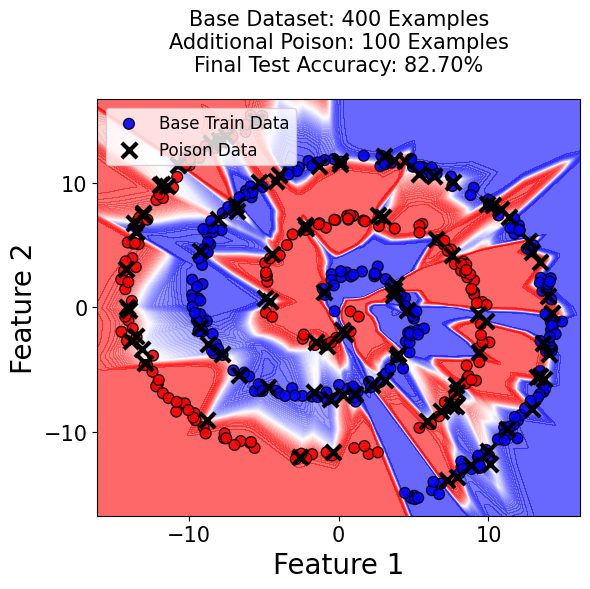

In [7]:
import importlib
importlib.reload(model_module)

model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_10.pt
Saved model: models_and_data/model_additional_10.pt
✅ Model saved to models_and_data\model_additional_20.pt
Saved model: models_and_data/model_additional_20.pt
✅ Model saved to models_and_data\model_additional_50.pt
Saved model: models_and_data/model_additional_50.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
